In [38]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import mplcyberpunk
import tqdm
from functions import nth_derivative#, Param_dirich

In [39]:

zi=0.0
zf=3.0
#t=torch.linspace(zi,zf,150).view(-1,1)
x0_i=0.2
x0_f=0.5

T=torch.cartesian_prod(torch.linspace(zi,zf,1500),
                       torch.linspace(x0_i,x0_f,40))

#random permutation of the training dataset T
T=T[torch.randperm(T.shape[0])]

#if avaliable, use cuda
if torch.cuda.is_available(): T.cuda()

#Neural network architecture

nodos=16
ANN = nn.Sequential(nn.Linear(2, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos)
                    nn.Tanh(),nn.Linear(nodos,1))
print(ANN)

if torch.cuda.is_available(): T.cuda()

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


In [40]:
def cost(T):
    x=ANN(T)
    z0=torch.zeros_like(T[:,1], requires_grad=True).view(-1,1)
    z0=torch.cat((z0, T[:,1].view(-1,1)), 1)
    #z0.requires_grad=True
    z=T[:,0].view(-1,1)
    Dx = nth_derivative(ANN,T,0,0,1)
    osc = Dx - (3*x / (1.0+z))
    omega_0 = ANN(z0) - T[:,1].view(-1,1)
    #print(omega_0)

    return torch.mean(osc**2) + torch.mean(omega_0**2)

In [41]:
cost(T)

tensor(0.2035, grad_fn=<AddBackward0>)

Training:   0%|                                                           | 0/10000 [00:00<?, ?it/s]

Training: 100%|███████████████████████████████████| 3000/3000 [06:42<00:00,  7.46it/s, loss=0.00214]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


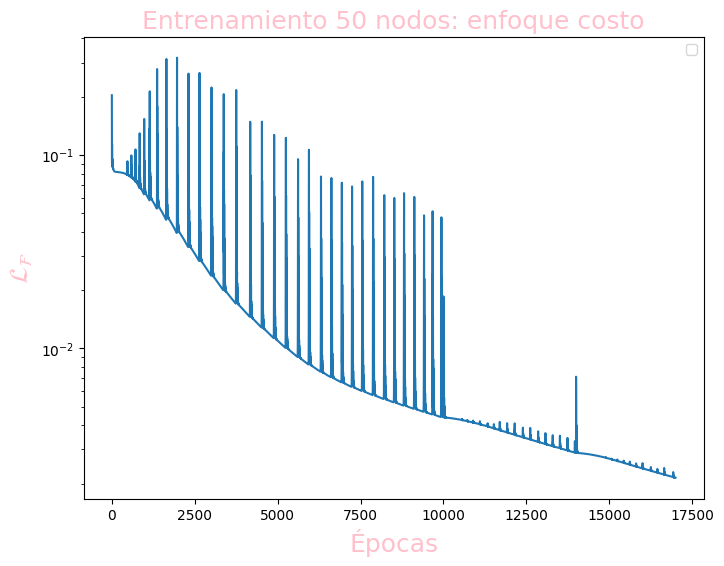

In [42]:

#Training loop
epochs=[10000,4000,3000]
tasas=[0.01,0.001,0.0005]
errores=[]
for k in range(len(epochs)):
    learning_rate=tasas[k]
    epocas=epochs[k]

    #optimizer=torch.optim.SGD(ANN.parameters(),lr=learning_rate,momentum=0.9)
    optimizer = torch.optim.Adam(ANN.parameters(), lr=learning_rate)
    pbar = tqdm.tqdm(range(epocas), desc="Training",  colour='cyan', ncols=100)
    for i in pbar:
        l=cost(T) #coste
        l.backward() #gradiente
        optimizer.step() #se actualizan los parámetros
        optimizer.zero_grad() #vacíamos el gradiente
        errores.append(float(l))
        pbar.set_postfix({'loss': l.item()})
plt.figure(figsize=(8, 6))
plt.plot(range(np.sum(epochs)),errores)
plt.xlabel('Épocas', size=18, color='pink')
plt.ylabel('$\mathcal{L}_\mathcal{F}$', size=18, color='pink')
plt.title('Entrenamiento 50 nodos: enfoque costo', size=18, color='pink')
plt.legend(loc='best')
plt.yscale('log')

In [43]:
cost(T)

tensor(0.0021, grad_fn=<AddBackward0>)

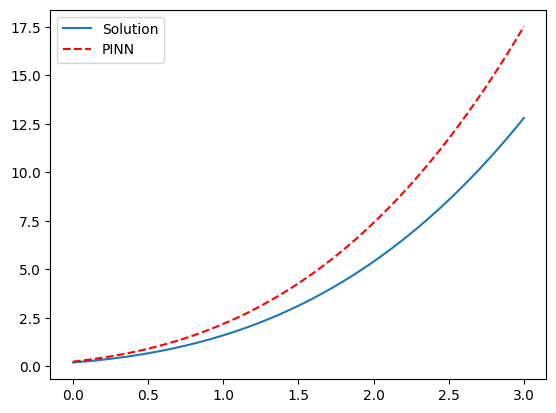

In [46]:
pos_ini=0.2
z0 = torch.linspace(zi,zf,60)
x0 = pos_ini*torch.ones([z0.shape[0],1])
#v0 = vel_ini*torch.ones([t0.shape[0],1])
# delta0 = d*torch.ones([t0.shape[0],1])
# omega0 = omega*torch.ones([t0.shape[0],1])

X=torch.cat((z0.view(-1,1),x0),1)
#X.cuda()
#plt.plot(t0, -torch.sin(t0)+2*t0+pos_ini, label='solución real')
#plt.plot(z0.detach(), sol_x([pos_ini,vel_ini], t0, d, omega), label='solución real')
plt.plot(z0,pos_ini * (z0+1)**3, label='Solution')
plt.plot(z0,ANN(X).detach().numpy(),'--r', label='PINN')
#plt.plot(t0.view(-1,1),Param(t0.view(-1,1)).detach().numpy(),'--r', label='PINN')
plt.legend()
plt.show()